In [202]:
# Importando as Bibliotecas Necessárias
import pandas as pd
import numpy as np

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn_lvq import GlvqModel

# Validação e métricas
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Bibliotecas adicionais
import optuna
from optuna.integration.mlflow import MLflowCallback
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [203]:
# Configurando o MLflow
mlflow.set_experiment("Modelagem de Classificação")

<Experiment: artifact_location='file:///c:/Users/PC/Documents/GitHub/diabetes/mlruns/490920415060799094', creation_time=1732409763939, experiment_id='490920415060799094', last_update_time=1732409763939, lifecycle_stage='active', name='Modelagem de Classificação', tags={}>

In [204]:
# Carregando os conjuntos de dados
train_data = pd.read_csv('train_data.csv')
validation_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:
# Separando features e target no conjunto de treinamento
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

# Separando features e target no conjunto de validação
X_val = validation_data.drop('class', axis=1)
y_val = validation_data['class']


In [208]:
# Definindo uma Função de Avaliação
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Treinando e avaliando o modelo com os dados originais
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_true = y_val
    X_val_used = X_val

    # Calculando as métricas
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val_used)
        if y_prob.ndim == 1 or y_prob.shape[1] == 2:
            y_prob = y_prob[:, -1]  # Para classes binárias
            roc_auc = roc_auc_score(y_true, y_prob)
        else:
            roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovo', average='weighted')
    else:
        roc_auc = None
    return acc, f1, recall, roc_auc


In [209]:
# Definindo os Modelos
models = {
    'K-NN': KNeighborsClassifier(),
    'LVQ': NearestCentroid(),
    'Árvore de Decisão': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Rede Neural MLP': MLPClassifier(max_iter=500),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

In [210]:
# Comitê de Redes Neurais Artificiais
# Definindo múltiplas redes neurais
nn1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=1)
nn2 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='sgd', max_iter=500, random_state=2)
nn3 = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=3)

# Criando o Comitê
committee_nn = VotingClassifier(estimators=[
    ('nn1', nn1),
    ('nn2', nn2),
    ('nn3', nn3)
], voting='soft')

models['Comitê de Redes Neurais Artificiais'] = committee_nn


In [211]:
# Comitê Heterogêneo (Stacking)
# Modelos base
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Modelo meta
from sklearn.linear_model import LogisticRegression
final_estimator = LogisticRegression()

# Criando o StackingClassifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

models['Comitê Heterogêneo (Stacking)'] = stacking_model

In [212]:
# Executando os Modelos Básicos e Registrando no MLflow
initial_results = []

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        acc, f1, recall, roc_auc = evaluate_model(model, X_train, y_train, X_val, y_val, model_name)
        mlflow.log_param("model_type", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", recall)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        # Salvar o modelo
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} - Acurácia: {acc}, F1-Score: {f1}, Recall: {recall}, ROC AUC: {roc_auc}")
        initial_results.append({
            'Modelo': model_name,
            'Acurácia': acc,
            'F1-Score': f1,
            'Recall': recall,
            'ROC AUC': roc_auc
        })

# Converte os resultados iniciais em DataFrame
initial_results_df = pd.DataFrame(initial_results)

# Exibindo os resultados iniciais
print(initial_results_df)

2024/11/24 01:28:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-NN - Acurácia: 0.8749487014129097, F1-Score: 0.8305980818922424, Recall: 0.8749487014129097, ROC AUC: 0.5054859295809839


2024/11/24 01:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LVQ - Acurácia: 0.5108166735064783, F1-Score: 0.5965374024166652, Recall: 0.5108166735064783, ROC AUC: None


2024/11/24 01:28:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Árvore de Decisão - Acurácia: 0.7972093568622852, F1-Score: 0.8035707856424888, Recall: 0.7972093568622852, ROC AUC: 0.5285752075717296


2024/11/24 01:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM - Acurácia: 0.8869672275312188, F1-Score: 0.8338362757298086, Recall: 0.8869672275312188, ROC AUC: None


2024/11/24 01:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Acurácia: 0.8863223310077973, F1-Score: 0.8340782091250809, Recall: 0.8863223310077973, ROC AUC: 0.6411218123035395


2024/11/24 01:31:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\xgboost\core.py:158: UserWarning: [01:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Rede Neural MLP - Acurácia: 0.8862050770944481, F1-Score: 0.8350171768105302, Recall: 0.8862050770944481, ROC AUC: 0.6526632715218965


2024/11/24 01:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Acurácia: 0.8854429266576772, F1-Score: 0.8368679264132897, Recall: 0.8854429266576772, ROC AUC: 0.6455116187509411
[LightGBM] [Info] Number of positive: 7714, number of negative: 60513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 68227, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113064 -> initscore=-2.059821
[LightGBM] [Info] Start training from score -2.059821


2024/11/24 01:31:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - Acurácia: 0.8870258544878935, F1-Score: 0.835878963507557, Recall: 0.8870258544878935, ROC AUC: 0.6652721930265553


2024/11/24 01:32:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê de Redes Neurais Artificiais - Acurácia: 0.8867327197045202, F1-Score: 0.8345094391946535, Recall: 0.8867327197045202, ROC AUC: 0.6561677114848266


2024/11/24 01:42:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê Heterogêneo (Stacking) - Acurácia: 0.8864982118778214, F1-Score: 0.8347251165452486, Recall: 0.8864982118778214, ROC AUC: 0.642877957724016
                                Modelo  Acurácia  F1-Score    Recall   ROC AUC
0                                 K-NN  0.874949  0.830598  0.874949  0.505486
1                                  LVQ  0.510817  0.596537  0.510817       NaN
2                    Árvore de Decisão  0.797209  0.803571  0.797209  0.528575
3                                  SVM  0.886967  0.833836  0.886967       NaN
4                        Random Forest  0.886322  0.834078  0.886322  0.641122
5                      Rede Neural MLP  0.886205  0.835017  0.886205  0.652663
6                              XGBoost  0.885443  0.836868  0.885443  0.645512
7                             LightGBM  0.887026  0.835879  0.887026  0.665272
8  Comitê de Redes Neurais Artificiais  0.886733  0.834509  0.886733  0.656168
9        Comitê Heterogêneo (Stacking)  0.886498  0.834725  0.8

In [213]:
# Busca de Hiperparâmetros com Optuna
# Configurando o Callback do MLflow para o Optuna
mlflc = MLflowCallback(tracking_uri=mlflow.get_tracking_uri(), metric_name='accuracy')


C:\Users\PC\AppData\Local\Temp\ipykernel_9704\2387988113.py:3: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(tracking_uri=mlflow.get_tracking_uri(), metric_name='accuracy')


In [214]:
def build_classifier(model_name, params):
    if model_name == 'K-NN':
        classifier = KNeighborsClassifier(
            n_neighbors=params['n_neighbors'],
            weights=params['weights'],
            algorithm=params['algorithm']
        )
    elif model_name == 'LVQ':
        classifier = NearestCentroid(
            metric=params['metric'],
            shrink_threshold=params['shrink_threshold']
        )
    elif model_name == 'Árvore de Decisão':
        classifier = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            criterion=params['criterion']
        )
    elif model_name == 'SVM':
        classifier = SVC(
            C=params['C'],
            kernel=params['kernel'],
            gamma=params['gamma']
        )
    elif model_name == 'Random Forest':
        classifier = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split']
        )
    elif model_name == 'Rede Neural MLP':
        classifier = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            alpha=params['alpha'],
            max_iter=500
        )
    elif model_name == 'Comitê de Redes Neurais Artificiais':
        nn1 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=1
        )
        nn2 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=2
        )
        nn3 = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            activation=params['activation'],
            solver=params['solver'],
            max_iter=500,
            random_state=3
        )
        classifier = VotingClassifier(
            estimators=[
                ('nn1', nn1),
                ('nn2', nn2),
                ('nn3', nn3)
            ],
            voting='soft'
        )
    elif model_name == 'Comitê Heterogêneo (Stacking)':
        final_estimator = LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver=params['solver']
        )
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(random_state=42)),
            ('knn', KNeighborsClassifier())
        ]
        classifier = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5
        )
    elif model_name == 'XGBoost':
        classifier = XGBClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            use_label_encoder=False,
            eval_metric='logloss'
        )
    elif model_name == 'LightGBM':
        classifier = LGBMClassifier(
            n_estimators=params['n_estimators'],
            num_leaves=params['num_leaves'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample']
        )
    else:
        raise ValueError(f"Modelo {model_name} não reconhecido.")
    return classifier


In [215]:
def objective_factory(model_name):
    def objective(trial):
        params = {}
        # Definir os hiperparâmetros para cada modelo
        if model_name == 'K-NN':
            params['n_neighbors'] = trial.suggest_int('n_neighbors', 1, 30)
            params['weights'] = trial.suggest_categorical('weights', ['uniform', 'distance'])
            params['algorithm'] = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        
        elif model_name == 'LVQ':
            params['metric'] = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
            use_shrinkage = trial.suggest_categorical('use_shrinkage', [True, False])
            params['shrink_threshold'] = trial.suggest_float('shrink_threshold', 0.0, 1.0) if use_shrinkage else None
        
        elif model_name == 'Árvore de Decisão':
            params['max_depth'] = trial.suggest_int('max_depth', 1, 20)
            params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
            params['criterion'] = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        
        elif model_name == 'SVM':
            params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
            params['kernel'] = trial.suggest_categorical('kernel', ['linear', 'rbf'])
            params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
        
        elif model_name == 'Random Forest':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['max_depth'] = trial.suggest_int('max_depth', 2, 20)
            params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
        
        elif model_name == 'Rede Neural MLP':
            params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
            params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
            params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
            params['alpha'] = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
        
        elif model_name == 'Comitê de Redes Neurais Artificiais':
            params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
            params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
            params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
        
        elif model_name == 'Comitê Heterogêneo (Stacking)':
            params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
            params['penalty'] = trial.suggest_categorical('penalty', ['l2'])
            params['solver'] = trial.suggest_categorical('solver', ['lbfgs'])
        
        elif model_name == 'XGBoost':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['max_depth'] = trial.suggest_int('max_depth', 3, 15)
            params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        elif model_name == 'LightGBM':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
            params['num_leaves'] = trial.suggest_int('num_leaves', 31, 150)
            params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        else:
            raise ValueError(f"Modelo {model_name} não reconhecido.")
        
        classifier = build_classifier(model_name, params)
        
        acc = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
        return acc
    return objective


In [ ]:
# Executando as Otimizações com Optuna
n_trials = 2  # Número de iterações

In [218]:
# Dicionário para armazenar os melhores modelos e seus scores
best_models = {}
best_params = {}
cv_results = {}


In [ ]:
for model_name in models.keys():
    print(f"Otimização para o modelo: {model_name}")
    study = optuna.create_study(direction='maximize', study_name='Modelagem', sampler=optuna.samplers.TPESampler(seed=124))
    study.optimize(objective_factory(model_name), n_trials=n_trials, callbacks=[mlflc])
    
    # Armazenando os melhores hiperparâmetros
    best_params[model_name] = study.best_params
    
    # Criando o classificador com os melhores hiperparâmetros
    classifier = build_classifier(model_name, best_params[model_name])
    
    # Armazenando o classificador
    best_models[model_name] = classifier
    
    # Armazenando os scores dos folds
    acc_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[model_name] = acc_scores


[I 2024-11-24 01:42:11,191] A new study created in memory with name: Modelagem


Otimização para o modelo: K-NN


[I 2024-11-24 01:42:18,874] Trial 0 finished with value: 0.8869362571910037 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 0 with value: 0.8869362571910037.
[I 2024-11-24 01:43:14,945] Trial 1 finished with value: 0.8869362571910037 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.8869362571910037.
[I 2024-11-24 01:43:22,448] Trial 2 finished with value: 0.8867750356378183 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 0 with value: 0.8869362571910037.
[I 2024-11-24 01:43:29,664] Trial 3 finished with value: 0.8869362571910037 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.8869362571910037.
[I 2024-11-24 01:43:39,327] Trial 4 finished with value: 0.8856171356265025 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 0 wit

Otimização para o modelo: LVQ


[I 2024-11-24 01:43:45,917] Trial 0 finished with value: 0.5102085562235421 and parameters: {'metric': 'euclidean', 'use_shrinkage': False}. Best is trial 0 with value: 0.5102085562235421.
[I 2024-11-24 01:43:46,415] Trial 1 finished with value: 0.5095783059121426 and parameters: {'metric': 'euclidean', 'use_shrinkage': True, 'shrink_threshold': 0.48093190148436094}. Best is trial 0 with value: 0.5102085562235421.
[I 2024-11-24 01:43:46,900] Trial 2 finished with value: 0.5101059577602903 and parameters: {'metric': 'euclidean', 'use_shrinkage': True, 'shrink_threshold': 0.05967789660956835}. Best is trial 0 with value: 0.5102085562235421.
[I 2024-11-24 01:43:47,446] Trial 3 finished with value: 0.5331026784311701 and parameters: {'metric': 'manhattan', 'use_shrinkage': True, 'shrink_threshold': 0.5315513738418384}. Best is trial 3 with value: 0.5331026784311701.
[I 2024-11-24 01:43:48,005] Trial 4 finished with value: 0.5327948798190674 and parameters: {'metric': 'manhattan', 'use_shri

Otimização para o modelo: Árvore de Decisão


[I 2024-11-24 01:43:49,646] Trial 0 finished with value: 0.8718688846226204 and parameters: {'max_depth': 14, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8718688846226204.
[I 2024-11-24 01:43:50,598] Trial 1 finished with value: 0.8683512199565122 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.8718688846226204.
[I 2024-11-24 01:43:51,375] Trial 2 finished with value: 0.8813959391012883 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8813959391012883.
[I 2024-11-24 01:43:52,098] Trial 3 finished with value: 0.8827297201976781 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8827297201976781.
[I 2024-11-24 01:43:52,577] Trial 4 finished with value: 0.8868189938252844 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 4 wi

Otimização para o modelo: SVM


[I 2024-11-24 02:56:11,381] Trial 0 finished with value: 0.8455597198426827 and parameters: {'C': 2.471373418487883, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.8455597198426827.
[I 2024-11-24 04:04:47,462] Trial 1 finished with value: 0.8709747562925326 and parameters: {'C': 0.7017992831138444, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.8709747562925326.
[I 2024-11-24 05:16:45,916] Trial 2 finished with value: 0.8746536951434984 and parameters: {'C': 0.4856865002051285, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.8746536951434984.
[I 2024-11-24 06:28:57,388] Trial 3 finished with value: 0.8438448521417896 and parameters: {'C': 2.9922013287804083, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.8746536951434984.
[I 2024-11-24 07:41:28,793] Trial 4 finished with value: 0.8559804472263565 and parameters: {'C': 1.856957298624054, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0

Otimização para o modelo: Random Forest


[I 2024-11-24 11:21:48,251] Trial 0 finished with value: 0.8869362571910037 and parameters: {'n_estimators': 224, 'max_depth': 7, 'min_samples_split': 4}. Best is trial 0 with value: 0.8869362571910037.
[I 2024-11-24 11:21:59,104] Trial 1 finished with value: 0.8871854262684783 and parameters: {'n_estimators': 188, 'max_depth': 15, 'min_samples_split': 5}. Best is trial 1 with value: 0.8871854262684783.
[I 2024-11-24 11:22:15,306] Trial 2 finished with value: 0.8872587078161847 and parameters: {'n_estimators': 296, 'max_depth': 15, 'min_samples_split': 6}. Best is trial 2 with value: 0.8872587078161847.
[I 2024-11-24 11:22:20,786] Trial 3 finished with value: 0.8869362571910037 and parameters: {'n_estimators': 148, 'max_depth': 8, 'min_samples_split': 8}. Best is trial 2 with value: 0.8872587078161847.
[I 2024-11-24 11:22:23,300] Trial 4 finished with value: 0.8869362571910037 and parameters: {'n_estimators': 160, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 2 with value: 0.8

Otimização para o modelo: Rede Neural MLP


c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
[I 2024-11-24 11:23:32,577] Trial 0 finished with value: 0.8862180529106201 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha

Otimização para o modelo: XGBoost


[I 2024-11-24 11:25:13,409] Trial 0 finished with value: 0.8870974808924205 and parameters: {'n_estimators': 224, 'max_depth': 6, 'learning_rate': 0.021631523301351215, 'subsample': 0.7756573845414456}. Best is trial 0 with value: 0.8870974808924205.
[I 2024-11-24 11:25:18,266] Trial 1 finished with value: 0.8788016326774372 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.281000856274069, 'subsample': 0.8424148692924316}. Best is trial 0 with value: 0.8870974808924205.
[I 2024-11-24 11:25:22,237] Trial 2 finished with value: 0.8869509016852716 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.032130356318619414, 'subsample': 0.8645248536920208}. Best is trial 0 with value: 0.8870974808924205.
[I 2024-11-24 11:25:24,363] Trial 3 finished with value: 0.8870095387387099 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.03872216488027652, 'subsample': 0.8689977028660179}. Best is trial 0 with value: 0.8870974808924205.


Otimização para o modelo: LightGBM


[I 2024-11-24 11:25:30,094] Trial 0 finished with value: 0.8870681650509906 and parameters: {'n_estimators': 224, 'num_leaves': 65, 'learning_rate': 0.021631523301351215, 'subsample': 0.7756573845414456}. Best is trial 0 with value: 0.8870681650509906.
[I 2024-11-24 11:25:32,171] Trial 1 finished with value: 0.8803112905624376 and parameters: {'n_estimators': 230, 'num_leaves': 81, 'learning_rate': 0.281000856274069, 'subsample': 0.8424148692924316}. Best is trial 0 with value: 0.8870681650509906.
[I 2024-11-24 11:25:34,210] Trial 2 finished with value: 0.8870241993447141 and parameters: {'n_estimators': 170, 'num_leaves': 78, 'learning_rate': 0.032130356318619414, 'subsample': 0.8645248536920208}. Best is trial 0 with value: 0.8870681650509906.
[I 2024-11-24 11:25:35,533] Trial 3 finished with value: 0.886980227193743 and parameters: {'n_estimators': 160, 'num_leaves': 38, 'learning_rate': 0.03872216488027652, 'subsample': 0.8689977028660179}. Best is trial 0 with value: 0.88706816505

[LightGBM] [Info] Number of positive: 6171, number of negative: 48410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 54581, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113061 -> initscore=-2.059846
[LightGBM] [Info] Start training from score -2.059846
[LightGBM] [Info] Number of positive: 6171, number of negative: 48410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 54581, number of used features: 82
[LightGBM] [Info] [b

[I 2024-11-24 11:25:38,119] A new study created in memory with name: Modelagem


[LightGBM] [Info] Number of positive: 6172, number of negative: 48410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 54582, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113078 -> initscore=-2.059683
[LightGBM] [Info] Start training from score -2.059683
Otimização para o modelo: Comitê de Redes Neurais Artificiais


c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
[I 2024-11-24 11:25:55,554] Trial 0 finished with value: 0.8862767082240264 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam'}. Best 

Otimização para o modelo: Comitê Heterogêneo (Stacking)


[I 2024-11-24 11:39:53,870] Trial 0 finished with value: 0.8871267999561976 and parameters: {'C': 2.471373418487883, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8871267999561976.
[I 2024-11-24 11:49:49,816] Trial 1 finished with value: 0.8870095419610571 and parameters: {'C': 0.37348973478010355, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8871267999561976.
[I 2024-11-24 11:59:38,731] Trial 2 finished with value: 0.8870388567283711 and parameters: {'C': 0.2842515929299161, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8871267999561976.
[I 2024-11-24 12:09:23,395] Trial 3 finished with value: 0.8870388567283711 and parameters: {'C': 1.2665709946616688, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8871267999561976.
[I 2024-11-24 12:19:08,196] Trial 4 finished with value: 0.8871267999561976 and parameters: {'C': 2.747501508681121, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8871

In [221]:
# Avaliação dos Melhores Modelos e Registro no MLflow
results = []

for model_name, model in best_models.items():
    with mlflow.start_run(run_name=f"{model_name} - Optuna HPO"):
        acc, f1, recall, roc_auc = evaluate_model(model, X_train, y_train, X_val, y_val, model_name)
        mlflow.log_params(best_params[model_name])
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", recall)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        # Salvar o modelo
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} com Optuna HPO - Acurácia: {acc}, F1-Score: {f1}, Recall: {recall}, ROC AUC: {roc_auc}")
        results.append({
            'Modelo': model_name,
            'Acurácia': acc,
            'F1-Score': f1,
            'Recall': recall,
            'ROC AUC': roc_auc
        })

# Converte os resultados em DataFrame
results_df = pd.DataFrame(results)

2024/11/24 13:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-NN com Optuna HPO - Acurácia: 0.8869672275312188, F1-Score: 0.8338362757298086, Recall: 0.8869672275312188, ROC AUC: 0.5076814499042672


2024/11/24 13:21:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LVQ com Optuna HPO - Acurácia: 0.5292841648590022, F1-Score: 0.6134318485707128, Recall: 0.5292841648590022, ROC AUC: None


2024/11/24 13:21:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Árvore de Decisão com Optuna HPO - Acurácia: 0.8872017353579176, F1-Score: 0.8353061398780758, Recall: 0.8872017353579176, ROC AUC: 0.6471695424878547


2024/11/24 14:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM com Optuna HPO - Acurácia: 0.8673271970452013, F1-Score: 0.8326484438148098, Recall: 0.8673271970452013, ROC AUC: None


2024/11/24 14:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest com Optuna HPO - Acurácia: 0.8870258544878935, F1-Score: 0.8344325256514796, Recall: 0.8870258544878935, ROC AUC: 0.6666185671825344


2024/11/24 14:40:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\PC\.conda\envs\venvmodel\lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Rede Neural MLP com Optuna HPO - Acurácia: 0.8869672275312188, F1-Score: 0.8338362757298086, Recall: 0.8869672275312188, ROC AUC: 0.6521497418192479


2024/11/24 14:40:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost com Optuna HPO - Acurácia: 0.8869086005745441, F1-Score: 0.8352673365968091, Recall: 0.8869086005745441, ROC AUC: 0.6699906050016882
[LightGBM] [Info] Number of positive: 7714, number of negative: 60513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 68227, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113064 -> initscore=-2.059821
[LightGBM] [Info] Start training from score -2.059821


2024/11/24 14:40:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM com Optuna HPO - Acurácia: 0.8869086005745441, F1-Score: 0.835045292038363, Recall: 0.8869086005745441, ROC AUC: 0.6671973380243872


2024/11/24 14:40:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê de Redes Neurais Artificiais com Optuna HPO - Acurácia: 0.8869672275312188, F1-Score: 0.8338362757298086, Recall: 0.8869672275312188, ROC AUC: 0.5596062486406668


2024/11/24 14:49:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Comitê Heterogêneo (Stacking) com Optuna HPO - Acurácia: 0.8864395849211467, F1-Score: 0.8346952830347404, Recall: 0.8864395849211467, ROC AUC: 0.642877957724016


In [222]:
# Selecionando o Melhor Modelo automaticamente com base na Acurácia
best_model_name = results_df.loc[results_df['Acurácia'].idxmax(), 'Modelo']
best_model = best_models[best_model_name]
print(f"O melhor modelo é: {best_model_name}")

O melhor modelo é: Árvore de Decisão


In [303]:
def pipeline_test_set(df):
    df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
    
    df = df.loc[~df.discharge_disposition_id.isin([11, 18, 19, 20, 21, 7, 25, 26])]
    
    df["race"].fillna(df["race"].mode()[0], inplace = True)
    
    df = df.loc[~df.gender.isin(['Unknown/Invalid'])]
    
    df = df.drop(['citoglipton', 'examide'], axis = 1)
    
    df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
    
    keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'insulin', 'glyburide.metformin', 'tolazamide', 'metformin.pioglitazone',
        'metformin.rosiglitazone', 'glimepiride.pioglitazone', 'glipizide.metformin',
        'troglitazone', 'tolbutamide', 'acetohexamide']
    for col in keys:
        colname = str(col) + 'temp'
        df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    df['numchange'] = 0
    for col in keys:
        colname = str(col) + 'temp'
        df['numchange'] = df['numchange'] + df[colname]
        del df[colname]

    df['change'] = df['change'].replace('Ch', 1)
    df['change'] = df['change'].replace('No', 0)
    df['gender'] = df['gender'].replace('Male', 1)
    df['gender'] = df['gender'].replace('Female', 0)
    df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
    df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

    for col in keys:
        df[col] = df[col].replace('No', 0)
        df[col] = df[col].replace('Steady', 1)
        df[col] = df[col].replace('Up', 1)
        df[col] = df[col].replace('Down', 1)
    df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
    df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
    df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
    df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
    df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
    df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
    df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
    df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)
    for i in range(0,10):
        df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
    df['class'] = df['class'].replace('>30', 0)
    df['class'] = df['class'].replace('<30', 1)
    df['class'] = df['class'].replace('NO', 0)
    df['diag_1'] = df['diag_1'].astype('object')
    df['diag_2'] = df['diag_2'].astype('object')
    df['diag_3'] = df['diag_3'].astype('object')

    df['level1_diag1'] = df['diag_1'].astype('object')
    df['level2_diag1'] = df['diag_1'].astype('object')
    df['level1_diag2'] = df['diag_2'].astype('object')
    df['level2_diag2'] = df['diag_2'].astype('object')
    df['level1_diag3'] = df['diag_3'].astype('object')
    df['level2_diag3'] = df['diag_3'].astype('object')
    df.loc[df['diag_1'].fillna('').str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
    df.loc[df['diag_1'].fillna('').str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
    df.loc[df['diag_2'].fillna('').str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
    df.loc[df['diag_2'].fillna('').str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
    df.loc[df['diag_3'].fillna('').str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
    df.loc[df['diag_3'].fillna('').str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0

    df['level1_diag1'] = df['level1_diag1'].fillna(-1)
    df['level2_diag1'] = df['level2_diag1'].fillna(-1)
    df['level1_diag2'] = df['level1_diag2'].fillna(-1)
    df['level2_diag2'] = df['level2_diag2'].fillna(-1)
    df['level1_diag3'] = df['level1_diag3'].fillna(-1)
    df['level2_diag3'] = df['level2_diag3'].fillna(-1)
    df['level1_diag1'] = df['level1_diag1'].astype(float)
    df['level2_diag1'] = df['level2_diag1'].astype(float)
    df['level1_diag2'] = df['level1_diag2'].astype(float)
    df['level2_diag2'] = df['level2_diag2'].astype(float)
    df['level1_diag3'] = df['level1_diag3'].astype(float)
    df['level2_diag3'] = df['level2_diag3'].astype(float)
    for index, row in df.iterrows():
        if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
            df.loc[index, 'level1_diag1'] = 1
        elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
            df.loc[index, 'level1_diag1'] = 2
        elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
            df.loc[index, 'level1_diag1'] = 3
        elif (np.floor(row['level1_diag1']) == 250):
            df.loc[index, 'level1_diag1'] = 4
        elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
            df.loc[index, 'level1_diag1'] = 5
        elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
            df.loc[index, 'level1_diag1'] = 6
        elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
            df.loc[index, 'level1_diag1'] = 7
        elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
            df.loc[index, 'level1_diag1'] = 8
        else:
            df.loc[index, 'level1_diag1'] = 0

        if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
            df.loc[index, 'level1_diag2'] = 1
        elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
            df.loc[index, 'level1_diag2'] = 2
        elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
            df.loc[index, 'level1_diag2'] = 3
        elif (np.floor(row['level1_diag2']) == 250):
            df.loc[index, 'level1_diag2'] = 4
        elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
            df.loc[index, 'level1_diag2'] = 5
        elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
            df.loc[index, 'level1_diag2'] = 6
        elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
            df.loc[index, 'level1_diag2'] = 7
        elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
            df.loc[index, 'level1_diag2'] = 8
        else:
            df.loc[index, 'level1_diag2'] = 0

        if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
            df.loc[index, 'level1_diag3'] = 1
        elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
            df.loc[index, 'level1_diag3'] = 2
        elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
            df.loc[index, 'level1_diag3'] = 3
        elif (np.floor(row['level1_diag3']) == 250):
            df.loc[index, 'level1_diag3'] = 4
        elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
            df.loc[index, 'level1_diag3'] = 5
        elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
            df.loc[index, 'level1_diag3'] = 6
        elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
            df.loc[index, 'level1_diag3'] = 7
        elif (row['level1_diag3'] >= 140 and row['level1_diag3'] < 240):
            df.loc[index, 'level1_diag3'] = 8
        else:
            df.loc[index, 'level1_diag3'] = 0
    for index, row in df.iterrows():
        if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
            df.loc[index, 'level2_diag1'] = 1
        elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
            df.loc[index, 'level2_diag1'] = 2
        elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
            df.loc[index, 'level2_diag1'] = 3
        elif (np.floor(row['level2_diag1']) == 785):
            df.loc[index, 'level2_diag1'] = 4
        elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
            df.loc[index, 'level2_diag1'] = 5
        elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
            df.loc[index, 'level2_diag1'] = 6
        elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
            df.loc[index, 'level2_diag1'] = 7
        elif (np.floor(row['level2_diag1']) == 786):
            df.loc[index, 'level2_diag1'] = 8
        elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
            df.loc[index, 'level2_diag1'] = 9
        elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
            df.loc[index, 'level2_diag1'] = 10
        elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
            df.loc[index, 'level2_diag1'] = 11
        elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
            df.loc[index, 'level2_diag1'] = 12
        elif (np.floor(row['level2_diag1']) == 787):
            df.loc[index, 'level2_diag1'] = 13
        elif (np.floor(row['level2_diag1']) == 250):
            df.loc[index, 'level2_diag1'] = 14
        elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
            df.loc[index, 'level2_diag1'] = 15
        elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
            df.loc[index, 'level2_diag1'] = 16
        elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
            df.loc[index, 'level2_diag1'] = 17
        elif (np.floor(row['level2_diag1']) == 788):
            df.loc[index, 'level2_diag1'] = 18
        elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
            df.loc[index, 'level2_diag1'] = 19
        elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
            df.loc[index, 'level2_diag1'] = 20
        elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
            df.loc[index, 'level2_diag1'] = 21
        elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
            df.loc[index, 'level2_diag1'] = 22
        else:
            df.loc[index, 'level2_diag1'] = 0

        if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
            df.loc[index, 'level2_diag2'] = 1
        elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
            df.loc[index, 'level2_diag2'] = 2
        elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
            df.loc[index, 'level2_diag2'] = 3
        elif (np.floor(row['level2_diag2']) == 785):
            df.loc[index, 'level2_diag2'] = 4
        elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
            df.loc[index, 'level2_diag2'] = 5
        elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
            df.loc[index, 'level2_diag2'] = 6
        elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
            df.loc[index, 'level2_diag2'] = 7
        elif (np.floor(row['level2_diag2']) == 786):
            df.loc[index, 'level2_diag2'] = 8
        elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
            df.loc[index, 'level2_diag2'] = 9
        elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
            df.loc[index, 'level2_diag2'] = 10
        elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
            df.loc[index, 'level2_diag2'] = 11
        elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
            df.loc[index, 'level2_diag2'] = 12
        elif (np.floor(row['level2_diag2']) == 787):
            df.loc[index, 'level2_diag2'] = 13
        elif (np.floor(row['level2_diag2']) == 250):
            df.loc[index, 'level2_diag2'] = 14
        elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
            df.loc[index, 'level2_diag2'] = 15
        elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
            df.loc[index, 'level2_diag2'] = 16
        elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
            df.loc[index, 'level2_diag2'] = 17
        elif (np.floor(row['level2_diag2']) == 788):
            df.loc[index, 'level2_diag2'] = 18
        elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
            df.loc[index, 'level2_diag2'] = 19
        elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
            df.loc[index, 'level2_diag2'] = 20
        elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
            df.loc[index, 'level2_diag2'] = 21
        elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
            df.loc[index, 'level2_diag2'] = 22
        else:
            df.loc[index, 'level2_diag2'] = 0


        if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
            df.loc[index, 'level2_diag3'] = 1
        elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
            df.loc[index, 'level2_diag3'] = 2
        elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
            df.loc[index, 'level2_diag3'] = 3
        elif (np.floor(row['level2_diag3']) == 785):
            df.loc[index, 'level2_diag3'] = 4
        elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
            df.loc[index, 'level2_diag3'] = 5
        elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
            df.loc[index, 'level2_diag3'] = 6
        elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
            df.loc[index, 'level2_diag3'] = 7
        elif (np.floor(row['level2_diag3']) == 786):
            df.loc[index, 'level2_diag3'] = 8
        elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
            df.loc[index, 'level2_diag3'] = 9
        elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
            df.loc[index, 'level2_diag3'] = 10
        elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
            df.loc[index, 'level2_diag3'] = 11
        elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
            df.loc[index, 'level2_diag3'] = 12
        elif (np.floor(row['level2_diag3']) == 787):
            df.loc[index, 'level2_diag3'] = 13
        elif (np.floor(row['level2_diag3']) == 250):
            df.loc[index, 'level2_diag3'] = 14
        elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
            df.loc[index, 'level2_diag3'] = 15
        elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
            df.loc[index, 'level2_diag3'] = 16
        elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
            df.loc[index, 'level2_diag3'] = 17
        elif (np.floor(row['level2_diag3']) == 788):
            df.loc[index, 'level2_diag3'] = 18
        elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
            df.loc[index, 'level2_diag3'] = 19
        elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
            df.loc[index, 'level2_diag3'] = 20
        elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
            df.loc[index, 'level2_diag3'] = 21
        elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
            df.loc[index, 'level2_diag3'] = 22
        else:
            df.loc[index, 'level2_diag3'] = 0
    df['age'] = df['age'].astype('int64')
    age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
    df['age'] = df.age.map(age_dict)
    categorical_columns = [
        'race', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
        'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin',
        'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone',
        'metformin.pioglitazone', 'change', 'diabetesMed'
    ]

    # Converter todas as colunas da lista para o tipo 'object'
    df[categorical_columns] = df[categorical_columns].astype('object')
    df['nummed'] = 0

    for col in keys:
        df['nummed'] = df['nummed'] + df[col]
    num_col = list(set(list(df._get_numeric_data().columns))- {'class'})
    statdataframe = pd.DataFrame()
    statdataframe['numeric_column'] = num_col
    skew_before = []
    skew_after = []

    kurt_before = []
    kurt_after = []

    standard_deviation_before = []
    standard_deviation_after = []

    log_transform_needed = []

    log_type = []

    for i in num_col:
        skewval = df[i].skew()
        skew_before.append(skewval)

        kurtval = df[i].kurtosis()
        kurt_before.append(kurtval)

        sdval = df[i].std()
        standard_deviation_before.append(sdval)

        if (abs(skewval) >2) & (abs(kurtval) >2):
            log_transform_needed.append('Yes')

            if len(df[df[i] == 0])/len(df) <=0.02:
                log_type.append('log')
                skewvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).skew()
                skew_after.append(skewvalnew)

                kurtvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)

                sdvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).std()
                standard_deviation_after.append(sdvalnew)

            else:
                log_type.append('log1p')
                skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
                skew_after.append(skewvalnew)

                kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)

                sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
                standard_deviation_after.append(sdvalnew)

        else:
            log_type.append('NA')
            log_transform_needed.append('No')

            skew_after.append(skewval)
            kurt_after.append(kurtval)
            standard_deviation_after.append(sdval)

    statdataframe['skew_before'] = skew_before
    statdataframe['kurtosis_before'] = kurt_before
    statdataframe['standard_deviation_before'] = standard_deviation_before
    statdataframe['log_transform_needed'] = log_transform_needed
    statdataframe['log_type'] = log_type
    statdataframe['skew_after'] = skew_after
    statdataframe['kurtosis_after'] = kurt_after
    statdataframe['standard_deviation_after'] = standard_deviation_after
    # executando a transformação de log para as colunas determinadas
    for i in range(len(statdataframe)):
        if statdataframe['log_transform_needed'][i] == 'Yes':
            colname = str(statdataframe['numeric_column'][i])

            if statdataframe['log_type'][i] == 'log':
                df = df[df[colname] > 0]
                df[colname + "_log"] = np.log(df[colname])

            elif statdataframe['log_type'][i] == 'log1p':
                df = df[df[colname] >= 0]
                df[colname + "_log1p"] = np.log1p(df[colname])
    df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)
    # numerics = list(set(list(df._get_numeric_data().columns))- {'class'})
    # features categorica
    df.change = df.change.astype('int64')
    df.diabetesMed = df.diabetesMed.astype('int64')

    # Converter dataframe para int64
    i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
            'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
            'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', \
            'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone','A1Cresult']
    df[i] = df[i].fillna(0).astype('int64')
    # dfcopy = df.copy(deep = True)
    df['class'] = df['class'].apply(lambda x: 0 if x == 2 else x)
    # descartar colunas de diagnóstico individuais que têm informações de doença muito granulares
    # também descartar categorização de nível 2 (que não era comparável com nenhuma referência)
    # também descartar diagnósticos secundários e terciários de nível 1
    df.drop(['diag_1', 'diag_2', 'diag_3', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3',
            'level2_diag3'], axis=1, inplace=True)
    interactionterms = [('num_medications','time_in_hospital'),
    ('num_medications','num_procedures'),
    ('time_in_hospital','num_lab_procedures'),
    ('num_medications','num_lab_procedures'),
    ('num_medications','number_diagnoses'),
    ('age','number_diagnoses'),
    ('change','num_medications'),
    ('number_diagnoses','time_in_hospital'),
    ('num_medications','numchange')]
    for inter in interactionterms:
        name = inter[0] + '|' + inter[1]
        df[name] = df[inter[0]] * df[inter[1]]
    df2 = df.copy(deep = True)
    df2['level1_diag1'] = df2['level1_diag1'].astype('object')
    df_pd = pd.get_dummies(df2, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                        'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'], drop_first = True)
    just_dummies = pd.get_dummies(df_pd['race'])
    df_pd = pd.concat([df_pd, just_dummies], axis=1)
    df_pd.drop(['race'], inplace=True, axis=1)
    non_num_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'max_glu_serum', 'A1Cresult', 'level1_diag1']
    num_cols = list(set(list(df._get_numeric_data().columns))- {'class', 'change'})
    new_non_num_cols = []
    for i in non_num_cols:
        for j in df_pd.columns:
            if i in j:
                new_non_num_cols.append(j)
    l = []
    for feature in list(df_pd.columns):
        if '|' in feature:
            l.append(feature)
    feature_set = [col for col in df_pd.columns if col != 'class']
    X_test = df_pd[feature_set]
    y_test = df_pd['class']

    return X_test, y_test

In [304]:
X_test, y_test = pipeline_test_set(test_data)

C:\Users\PC\AppData\Local\Temp\ipykernel_9704\1344644402.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["race"].fillna(df["race"].mode()[0], inplace = True)
C:\Users\PC\AppData\Local\Temp\ipykernel_9704\1344644402.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change'] = df['change

In [309]:
# Garantindo que o conjunto de teste tenha as mesmas colunas que o conjunto de treino
colunas_faltantes = [col for col in X_train.columns if col not in X_test.columns]
colunas_extras = [col for col in X_test.columns if col not in X_train.columns]

# Adicionando colunas faltantes no conjunto de teste
for col in colunas_faltantes:
    X_test[col] = np.nan

# Removendo colunas extras do conjunto de teste
X_test.drop(columns=colunas_extras, inplace=True)

# Reordenando as colunas do X_test para que fiquem na mesma ordem que X_combined
X_test = X_test[X_train.columns]


In [310]:
# Treinando o Melhor Modelo no Conjunto Combinado e Avaliando no Conjunto de Teste
# Combinando os conjuntos de treinamento e validação
X_combined = pd.concat([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Treinando o melhor modelo
best_model.fit(X_combined, y_combined)

# Avaliando no conjunto de teste sem modificar os dados originais
y_pred_test = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
if hasattr(best_model, "predict_proba"):
    y_prob_test = best_model.predict_proba(X_test)
    if y_prob_test.ndim == 1 or y_prob_test.shape[1] == 2:
        y_prob_test = y_prob_test[:, -1]  # Para classes binárias
        roc_auc_test = roc_auc_score(y_test, y_prob_test)
    else:
        roc_auc_test = roc_auc_score(y_test, y_prob_test, multi_class='ovo', average='weighted')
else:
    roc_auc_test = None

print(f"Desempenho no conjunto de teste - Acurácia: {acc_test}, F1-Score: {f1_test}, Recall: {recall_test}, ROC AUC: {roc_auc_test}")


Desempenho no conjunto de teste - Acurácia: 0.8874422511549769, F1-Score: 0.8353348641997256, Recall: 0.8874422511549769, ROC AUC: 0.6607698919043998


In [311]:
# Registrando no MLflow
with mlflow.start_run(run_name="Melhor Modelo - Teste"):
    mlflow.log_param("model_type", best_model_name)
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("recall_test", recall_test)
    if roc_auc_test is not None:
        mlflow.log_metric("roc_auc_test", roc_auc_test)
    mlflow.sklearn.log_model(best_model, "Melhor_Modelo")


2024/11/24 18:31:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


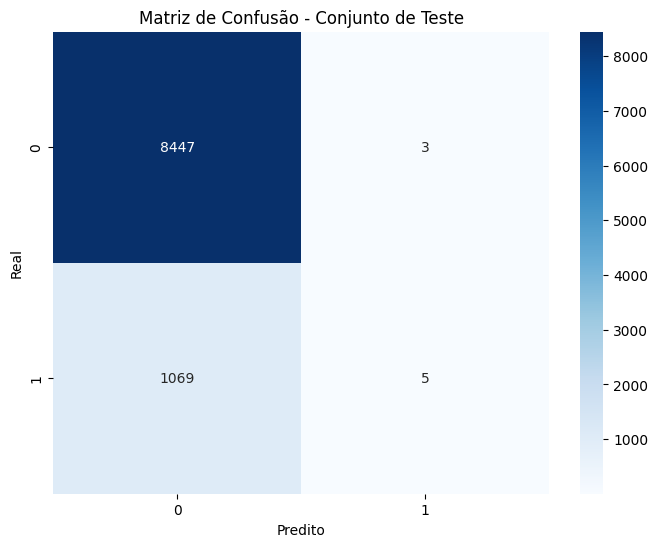

In [312]:
# Visualizações Adicionais
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
plt.title("Matriz de Confusão - Conjunto de Teste")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

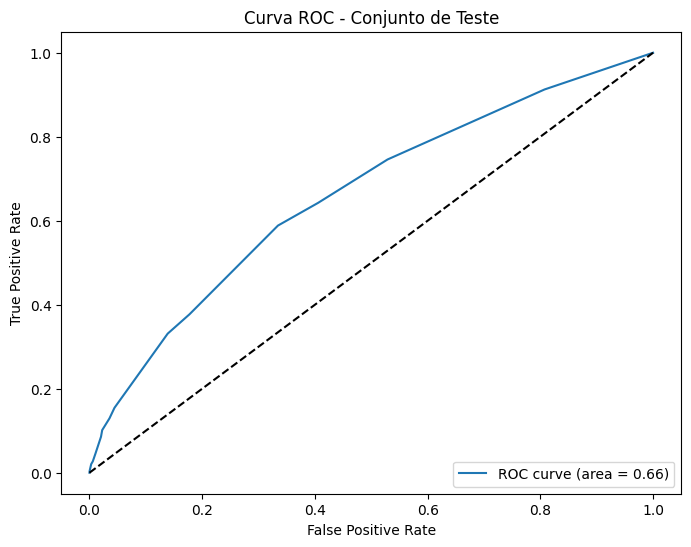

In [313]:
# Curva ROC
if roc_auc_test is not None and len(np.unique(y_test)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Conjunto de Teste')
    plt.legend(loc='lower right')
    plt.show()
elif roc_auc_test is not None:
    print("Curva ROC para problemas multiclasse não está implementada neste código.")


In [314]:
# Comparação dos Modelos
# Já temos o DataFrame results_df com as métricas dos modelos
print(results_df)

                                Modelo  Acurácia  F1-Score    Recall   ROC AUC
0                                 K-NN  0.886967  0.833836  0.886967  0.507681
1                                  LVQ  0.529284  0.613432  0.529284       NaN
2                    Árvore de Decisão  0.887202  0.835306  0.887202  0.647170
3                                  SVM  0.867327  0.832648  0.867327       NaN
4                        Random Forest  0.887026  0.834433  0.887026  0.666619
5                      Rede Neural MLP  0.886967  0.833836  0.886967  0.652150
6                              XGBoost  0.886909  0.835267  0.886909  0.669991
7                             LightGBM  0.886909  0.835045  0.886909  0.667197
8  Comitê de Redes Neurais Artificiais  0.886967  0.833836  0.886967  0.559606
9        Comitê Heterogêneo (Stacking)  0.886440  0.834695  0.886440  0.642878


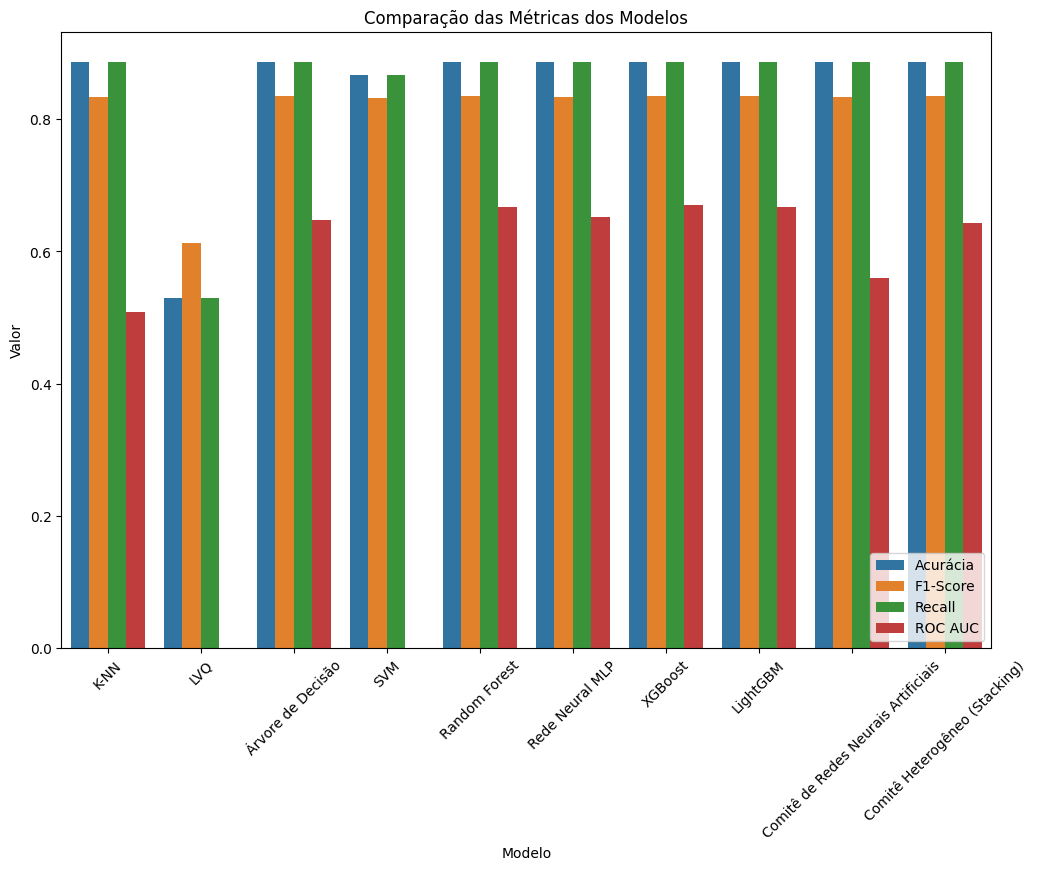

In [315]:
# Plotando as métricas
results_df_melted = results_df.melt(id_vars='Modelo', value_vars=['Acurácia', 'F1-Score', 'Recall', 'ROC AUC'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12,8))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=results_df_melted)
plt.xticks(rotation=45)
plt.title('Comparação das Métricas dos Modelos')
plt.legend(loc='lower right')
plt.show()

In [318]:
# Implementação da Metodologia de Janez Demsar
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Usando os scores de cross-validation armazenados em cv_results
scores_df = pd.DataFrame(cv_results)

# Teste de Friedman
stat, p = friedmanchisquare(*[scores_df[model] for model in scores_df.columns])
print(f'Estatística: {stat}, p-valor: {p}')

# Se p-valor < 0.05, há diferença significativa
if p < 0.05:
    print('Diferença significativa entre os modelos. Realizando teste de Nemenyi.')
    nemenyi = sp.posthoc_nemenyi_friedman(scores_df)
    print(nemenyi)
else:
    print('Não há diferença significativa entre os modelos.')

Estatística: 34.814303638644944, p-valor: 6.424810596432184e-05
Diferença significativa entre os modelos. Realizando teste de Nemenyi.
                                         K-NN       LVQ  Árvore de Decisão  \
K-NN                                 1.000000  0.572784           1.000000   
LVQ                                  0.572784  1.000000           0.572784   
Árvore de Decisão                    1.000000  0.572784           1.000000   
SVM                                  0.886843  0.999959           0.886843   
Random Forest                        0.839286  0.009665           0.839286   
Rede Neural MLP                      1.000000  0.572784           1.000000   
XGBoost                              0.886843  0.014062           0.886843   
LightGBM                             0.572784  0.001890           0.572784   
Comitê de Redes Neurais Artificiais  1.000000  0.572784           1.000000   
Comitê Heterogêneo (Stacking)        0.886843  0.014062           0.886843   

      